In [1]:
# Install fairlearn if not already installed
# !pip install fairlearn

import pandas as pd
from fairlearn.datasets import fetch_diabetes_hospital

# Fetch dataset
dataset = fetch_diabetes_hospital(as_frame=True)
df = dataset.frame  # This is a Pandas DataFrame

# Check basic info
print(f"Dataset shape: {df.shape}")
print(df.head())

# Save DataFrame to CSV
csv_file_path = "C:\\Users\\dorai\\OneDrive\\Documents\\Documents\\SEM6\\BigData\\PROJECT\\diabetes_hospital_data.csv"
df.to_csv(csv_file_path, index=False)

print(f"✅ Dataset saved successfully as '{csv_file_path}'!")


Dataset shape: (101766, 25)
              race  gender                    age discharge_disposition_id  \
0        Caucasian  Female  '30 years or younger'                    Other   
1        Caucasian  Female  '30 years or younger'     'Discharged to Home'   
2  AfricanAmerican  Female  '30 years or younger'     'Discharged to Home'   
3        Caucasian    Male          '30-60 years'     'Discharged to Home'   
4        Caucasian    Male          '30-60 years'     'Discharged to Home'   

  admission_source_id  time_in_hospital medical_specialty  num_lab_procedures  \
0            Referral                 1             Other                  41   
1           Emergency                 3           Missing                  59   
2           Emergency                 2           Missing                  11   
3           Emergency                 2           Missing                  44   
4           Emergency                 1           Missing                  51   

   num_procedure

In [1]:
!pip install pyspark pandas numpy scikit-learn imbalanced-learn matplotlib imbalanced-learn


In [ ]:
# ## Phase 1: Pre-processing & Exploratory Plots

# %% [python]
# Cell 1: Imports & Spark Setup
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean, stddev, abs
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array
from pyspark import SparkContext

# Stop any existing SparkContext
try:
    SparkContext.getOrCreate().stop()
except:
    pass
# Create SparkSession
spark = (SparkSession.builder
         .master("local[*]")
         .config("spark.driver.bindAddress","127.0.0.1")
         .config("spark.driver.host","127.0.0.1")
         .appName("Phase1_Preprocessing")
         .getOrCreate())
print("SparkSession ready for Phase 1")

SparkSession ready for Phase 1


+---------------+------+--------------------+------------------------+-------------------+----------------+-----------------+------------------+--------------+---------------+-----------------+----------------+-------------+---------+-------+------+-----------+--------+--------+-------------+------------------+-------------------+----------+--------------+---------------+
|           race|gender|                 age|discharge_disposition_id|admission_source_id|time_in_hospital|medical_specialty|num_lab_procedures|num_procedures|num_medications|primary_diagnosis|number_diagnoses|max_glu_serum|A1Cresult|insulin|change|diabetesMed|medicare|medicaid|had_emergency|had_inpatient_days|had_outpatient_days|readmitted|readmit_binary|readmit_30_days|
+---------------+------+--------------------+------------------------+-------------------+----------------+-----------------+------------------+--------------+---------------+-----------------+----------------+-------------+---------+-------+------+-

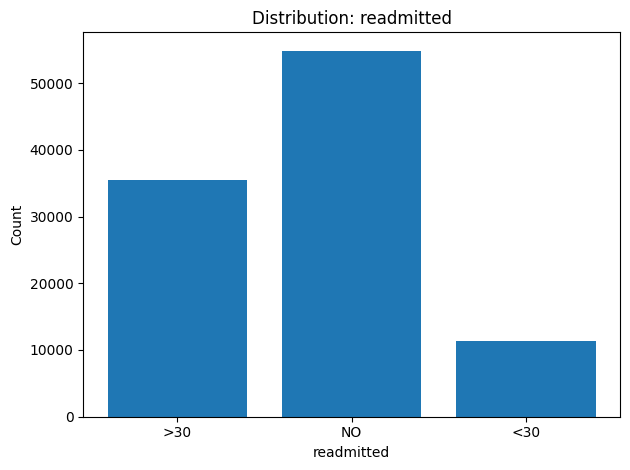

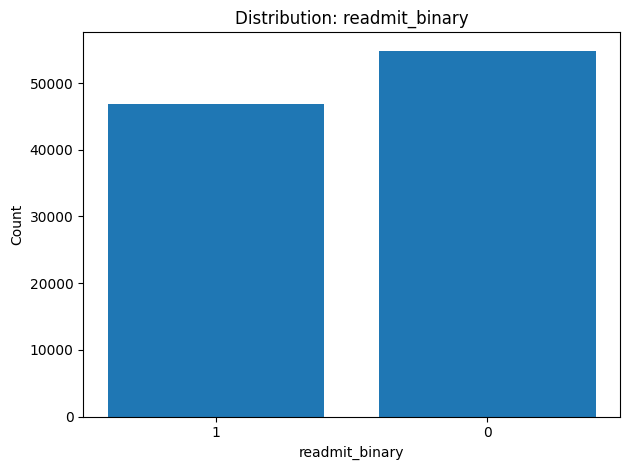

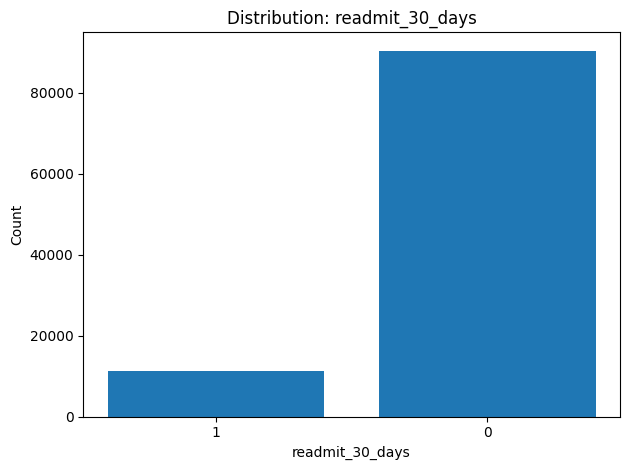

In [3]:
# Cell 2: Load Raw Data + Exploratory Plots
raw_df = spark.read.csv('diabetes_hospital_data.csv', header=True, inferSchema=True)
# Show head to confirm labels
raw_df.show(5)

# Exploratory: class distribution for each label
for lab in ['readmitted','readmit_binary','readmit_30_days']:
    counts = raw_df.groupBy(lab).count().toPandas()
    plt.figure(); plt.bar(counts[lab].astype(str), counts['count'])
    plt.title(f"Distribution: {lab}"); plt.xlabel(lab); plt.ylabel('Count')
    plt.tight_layout(); plt.show()

In [4]:
# Cell 3: Missing-Value Handling
num_cols = [c for c,t in raw_df.dtypes if t in ('int','double')]
cat_cols = [c for c,t in raw_df.dtypes if t=='string' and c not in ['readmitted','readmit_binary','readmit_30_days']]
medians = raw_df.approxQuantile(num_cols, [0.5], 0.01)
med_dict = {c:m[0] for c,m in zip(num_cols,medians)}
df = raw_df
for c in num_cols:
    df = df.withColumn(c, when(col(c).isNull(), med_dict[c]).otherwise(col(c)))
for c in cat_cols:
    df = df.withColumn(c, when(col(c).isNull()|(col(c)==''), 'Unknown').otherwise(col(c)))
print('Missing values imputed')

Missing values imputed


In [5]:
# Cell 4: Remove Hospice/Outliers
# filter hospice/deceased
df = df.filter(~col('discharge_disposition_id').isin('Hospice','Expired','Transferred to Hospice'))
st = df.select(*[mean(c).alias('m_'+c) for c in num_cols], *[stddev(c).alias('s_'+c) for c in num_cols]).collect()[0]
for c in num_cols:
    m,s = st['m_'+c], st['s_'+c]
    if s and s>0:
        df = df.filter(abs(col(c)-m) <= 3*s)
print('Outliers removed')

Outliers removed


In [6]:
# Cell 5: ICD-9 Grouping & Feature Engineering
from pyspark.sql.functions import when as w
df = df.withColumn('diag_group',
    w(col('primary_diagnosis')=='Diabetes','Endocrine')
   .when(col('primary_diagnosis')=='Respiratory Issues','Respiratory')
   .when(col('primary_diagnosis')=='Genitourinary Issues','Genitourinary')
   .when(col('primary_diagnosis')=='Musculoskeletal Issues','Musculoskeletal')
   .otherwise('Other'))
df = df.withColumn('age_num',
    w(col('age')=="'30 years or younger'",30)
   .when(col('age')=="'30-60 years'",45)
   .otherwise(75))
df = df.withColumn('total_visits',
    col('had_inpatient_days').cast('int') + col('had_outpatient_days').cast('int') + col('had_emergency').cast('int'))
print('Features diag_group, age_num, total_visits added')

Features diag_group, age_num, total_visits added


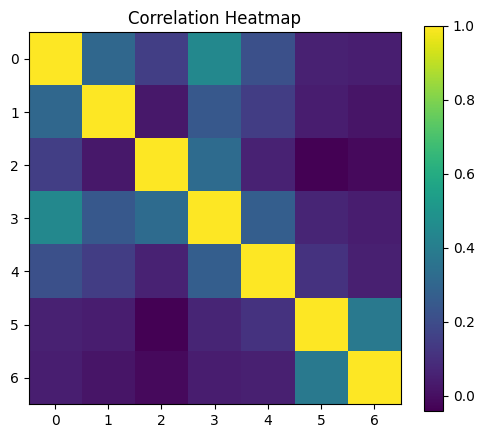

In [7]:
# Cell 6: Encoding + Vector Assembly + Correlation Heatmap
enc_cols = [c for c in cat_cols if c!='primary_diagnosis'] + ['diag_group']
indexers = [StringIndexer(inputCol=c,outputCol=c+'_idx',handleInvalid='keep') for c in enc_cols]
encoders = [OneHotEncoder(inputCol=c+'_idx',outputCol=c+'_vec') for c in enc_cols]
features = [c+'_vec' for c in enc_cols] + ['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_diagnoses','age_num','total_visits']
pipe = Pipeline(stages=indexers+encoders+[VectorAssembler(inputCols=features,outputCol='features_vec'),StandardScaler(inputCol='features_vec',outputCol='features_scaled')])
processed = pipe.fit(df).transform(df)
num_pdf = processed.select(num_cols).toPandas()
plt.figure(figsize=(6,5)); plt.imshow(num_pdf.corr(),interpolation='nearest'); plt.colorbar(); plt.title('Correlation Heatmap'); plt.show()

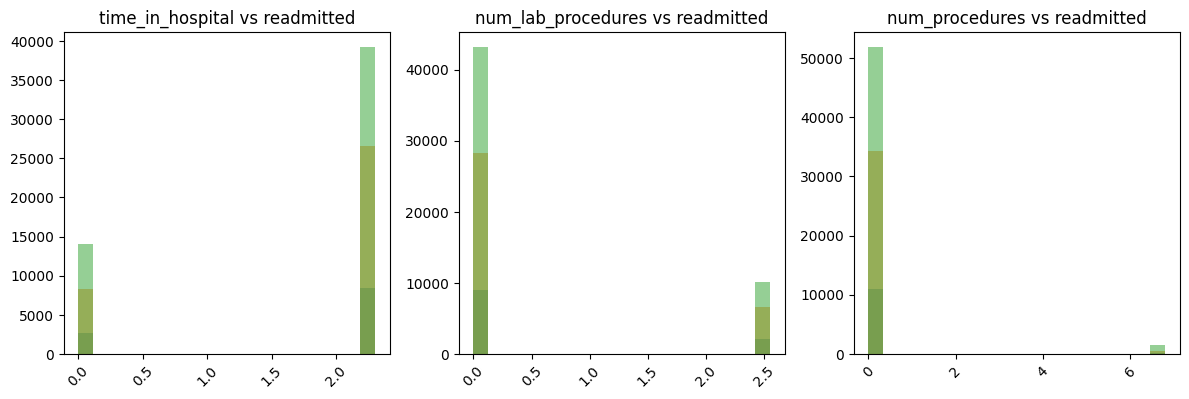

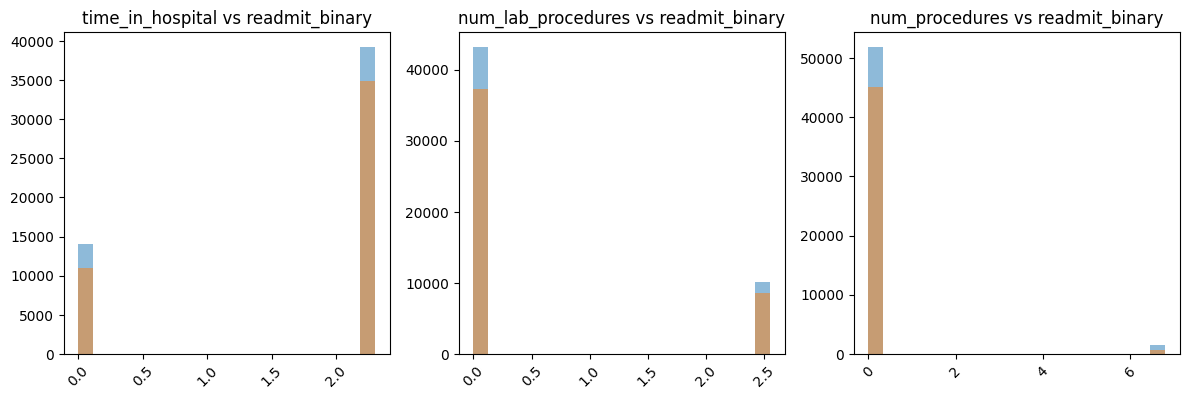

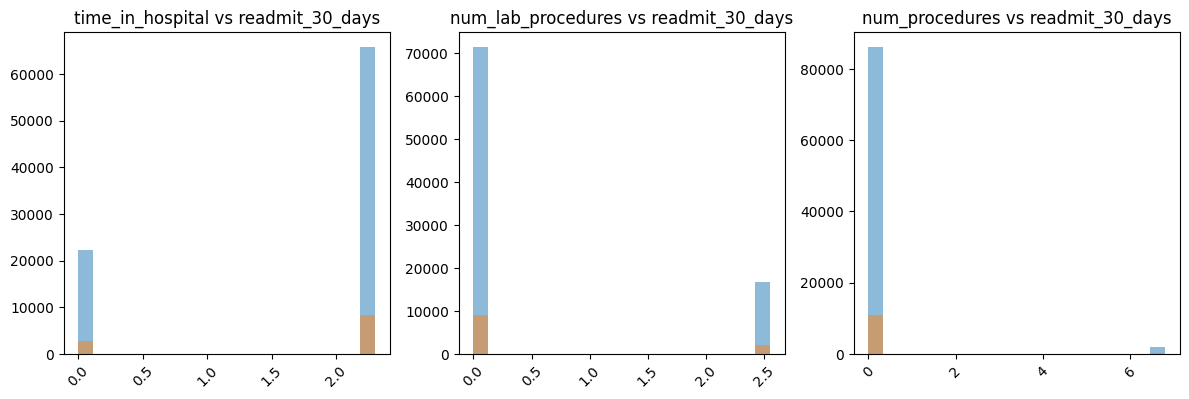

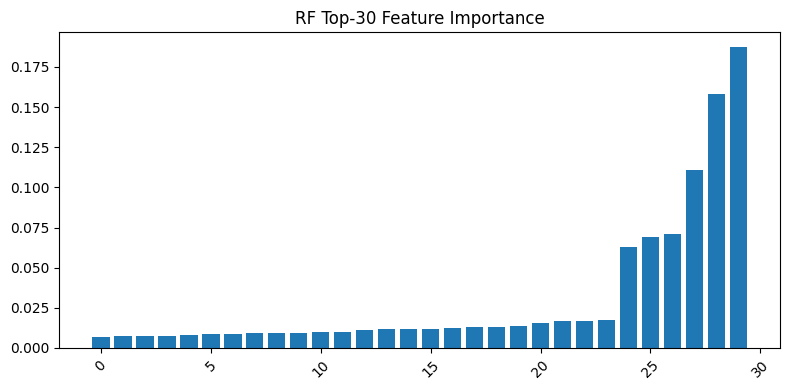

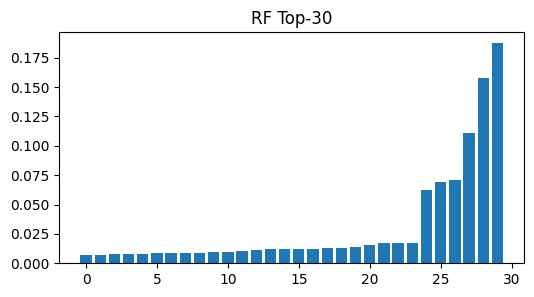

In [8]:
# Cell 7: Pandas-Side Histograms + RF Importance
arr = processed.select(vector_to_array('features_scaled').alias('features'),'readmitted','readmit_binary','readmit_30_days').toPandas()
X = np.vstack(arr['features'].values)
# show histograms for first 3 numeric
targets = ['readmitted','readmit_binary','readmit_30_days']
for t in targets:
    y = arr[t].values
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))  # wider figure for readability
    for i, cname in enumerate(num_cols[:3]):
        for cls in np.unique(y):
            ax[i].hist(X[y==cls, i], bins=20, alpha=0.5)
        ax[i].set_title(f"{cname} vs {t}")
        ax[i].tick_params(axis='x', rotation=45)
    fig.subplots_adjust(wspace=0.6)  # add horizontal space between subplots
    plt.tight_layout()
    plt.show()
# RF importance
y_all = arr['readmit_binary'].values
from sklearn.feature_selection import VarianceThreshold
X_sel = VarianceThreshold(0.01).fit_transform(X)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_sel, y_all)
imp = rf.feature_importances_
idx_top = np.argsort(imp)[-30:]
plt.figure(figsize=(8, 4))
plt.bar(range(len(idx_top)), imp[idx_top])
plt.title('RF Top-30 Feature Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# RF importance continue

y_all = arr['readmit_binary'].values
from sklearn.feature_selection import VarianceThreshold
X_sel = VarianceThreshold(0.01).fit_transform(X)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,random_state=42).fit(X_sel,y_all)
imp = rf.feature_importances_; idx_top=np.argsort(imp)[-30:]
plt.figure(figsize=(6,3)); plt.bar(range(len(idx_top)),imp[idx_top]); plt.title('RF Top-30'); plt.show()

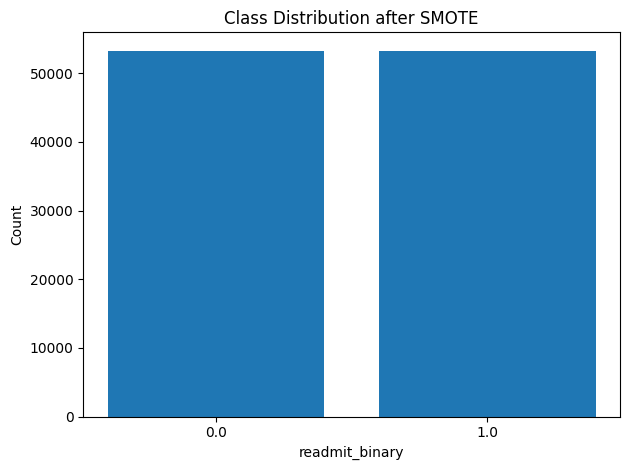

Phase 1 complete! CSV saved to output_csv/phase1_ready.csv


In [9]:
# Cell 8: Save Preprocessed Data to CSV (avoid Hadoop issues)
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler as SS
from sklearn.decomposition import PCA
import os

# Select top features and corresponding binary label
early_X = X_sel[:, idx_top]        # features from variance-threshold + RF selection
early_y = arr['readmit_binary'].values  # matching label length

# Apply SMOTE on these
X2, y2 = SMOTE(random_state=42).fit_resample(early_X, early_y)

# Plot class distribution after SMOTE
unique, counts_sm = np.unique(y2, return_counts=True)
plt.figure()
plt.bar(unique.astype(str), counts_sm)
plt.title('Class Distribution after SMOTE')
plt.xlabel('readmit_binary')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Continue with scaling and PCA
X2 = SS().fit_transform(X2)
X2 = PCA(n_components=min(45, X2.shape[1]), random_state=42).fit_transform(X2)

# Build final pandas DataFrame with features and binary label only
pdf_out = pd.DataFrame(X2, columns=[f'f{i}' for i in range(X2.shape[1])])
pdf_out['readmit_binary'] = y2

# Ensure output directory
os.makedirs('output_csv', exist_ok=True)
# Save to CSV
csv_path = 'output_csv/phase1_ready.csv'
pdf_out.to_csv(csv_path, index=False)
print(f'Phase 1 complete! CSV saved to {csv_path}')

In [10]:
# Cell 9: Imports & Spark Setup for Phase 2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score

# Start SparkSession (reuse local[*])
spark = (SparkSession.builder
         .master("local[*]")
         .appName("Phase2_Training")
         .getOrCreate())
print("SparkSession ready for Phase 2")

SparkSession ready for Phase 2


In [17]:
# Cell 10: Load SMOTE CSV, assemble features, and split

# 1. Read the Phase 1 CSV
phase1_csv = "output_csv/phase1_ready.csv"
assert os.path.exists(phase1_csv), f"Phase 1 file not found: {phase1_csv}"
df = spark.read.csv(phase1_csv, header=True, inferSchema=True)

# 2. Identify feature columns and label
feature_cols = [c for c in df.columns if c.startswith("f")]
label_col    = "readmit_binary"

# 3. Assemble vector
vec_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_feat = vec_assembler.transform(df).select("features", label_col).cache()

# 4. Split
train_sdf, test_sdf = df_feat.randomSplit([0.7,0.3], seed=42)
print(f"Train/Test sizes: {train_sdf.count()} / {test_sdf.count()}")

# 5. Persist splits for later use
train_sdf = train_sdf.cache()
test_sdf  = test_sdf.cache()


Train/Test sizes: 74911 / 31661


In [18]:
# Cell 11: Train & save models

# Define baselines
models = {
    "RandomForest": RandomForestClassifier(featuresCol="features", labelCol=label_col, numTrees=100, seed=42),
    "GBT":           GBTClassifier(featuresCol="features", labelCol=label_col, maxIter=100, seed=42),
    "LogReg":        LogisticRegression(featuresCol="features", labelCol=label_col, maxIter=50),
    "MLP":           MultilayerPerceptronClassifier(
                        featuresCol="features", 
                        labelCol=label_col, 
                        layers=[len(feature_cols),64,32,2],
                        maxIter=50, 
                        seed=42
                    )
}

# Directory for saving
os.makedirs("output/saved_models", exist_ok=True)

trained_models = {}
for name, estimator in models.items():
    print(f"▶️ Training {name} …")
    mdl = estimator.fit(train_sdf)
    path = f"output/saved_models/{name}"
    # save Spark ML model
    try:
        mdl.write().overwrite().save(path)
        print(f"✔️ Saved {name} → {path}")
    except Exception as e:
        print(f"⚠️ Could not save {name}: {e}")
    trained_models[name] = mdl


▶️ Training RandomForest …
⚠️ Could not save RandomForest: An error occurred while calling o2280.save.
: java.lang.RuntimeException: java.io.FileNotFoundException: java.io.FileNotFoundException: HADOOP_HOME and hadoop.home.dir are unset. -see https://wiki.apache.org/hadoop/WindowsProblems
	at org.apache.hadoop.util.Shell.getWinUtilsPath(Shell.java:735)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:270)
	at org.apache.hadoop.util.Shell.getSetPermissionCommand(Shell.java:286)
	at org.apache.hadoop.fs.RawLocalFileSystem.setPermission(RawLocalFileSystem.java:978)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkOneDirWithMode(RawLocalFileSystem.java:660)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:700)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirs(RawLocalFileSystem.java:672)
	at org.apache.hadoop.fs.RawLocalFileSystem.mkdirsWithOptionalPermission(RawLocalFileSystem.java:699)
	at org.apache.hadoop.fs.RawLocalFileS

In [19]:
# Cell 12: Predict on test set & collect predictions

# Evaluator for ROC-AUC later
evaluator = BinaryClassificationEvaluator(
    labelCol=label_col, 
    rawPredictionCol="probability",
    metricName="areaUnderROC"
)

# We'll collect into a dict of Pandas DataFrames
predictions = {}
metrics = []

for name, mdl in trained_models.items():
    print(f"▶️ Predicting with {name} …")
    sdf_pred = mdl.transform(test_sdf).select("probability", "prediction", label_col)
    
    # To avoid socket timeouts, reduce to a single partition before collect
    sdf_pred = sdf_pred.coalesce(1).cache()
    
    pdf = sdf_pred.toPandas()
    y_true = pdf[label_col].astype(int)
    y_pred = pdf["prediction"].astype(int)
    # extract probability of class=1
    y_prob = pdf["probability"].apply(lambda v: float(v[1]))

    # compute metrics
    auc_roc = evaluator.evaluate(sdf_pred)
    pr_auc  = average_precision_score(y_true, y_prob)
    report  = classification_report(y_true, y_pred, output_dict=True)
    metrics.append({
        "model": name,
        "accuracy":     report["accuracy"],
        "precision":    report["weighted avg"]["precision"],
        "recall":       report["weighted avg"]["recall"],
        "f1_score":     report["weighted avg"]["f1-score"],
        "roc_auc":      auc_roc,
        "pr_auc":       pr_auc
    })
    predictions[name] = (y_true, y_pred, y_prob)

print("✅ Predictions collected.")


▶️ Predicting with RandomForest …
▶️ Predicting with GBT …
▶️ Predicting with LogReg …
▶️ Predicting with MLP …
✅ Predictions collected.


In [21]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



🔍 Plots for RandomForest


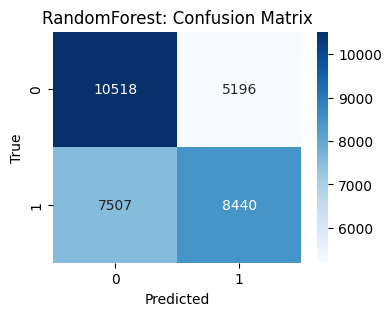

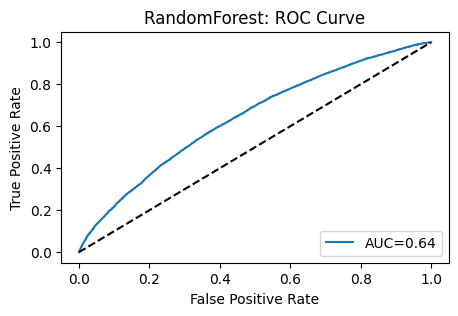

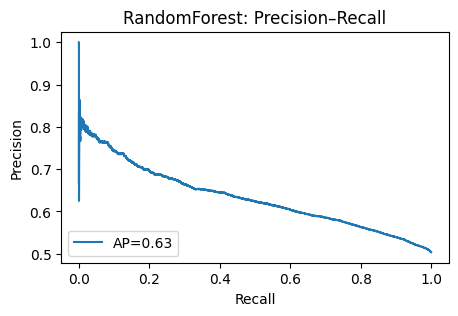


🔍 Plots for GBT


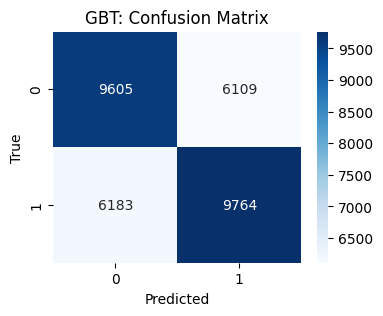

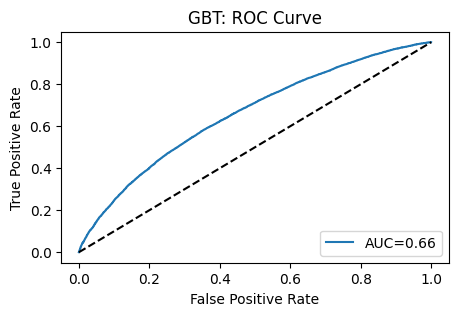

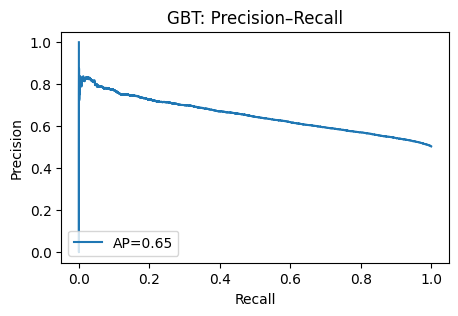


🔍 Plots for LogReg


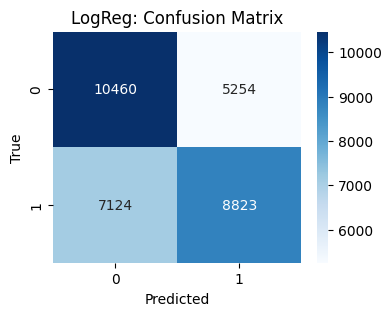

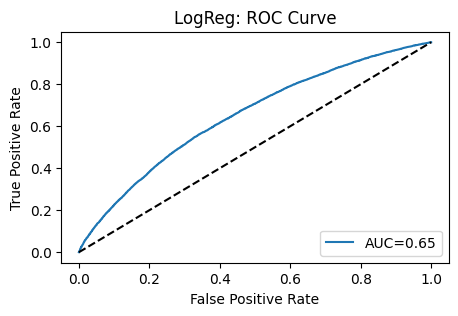

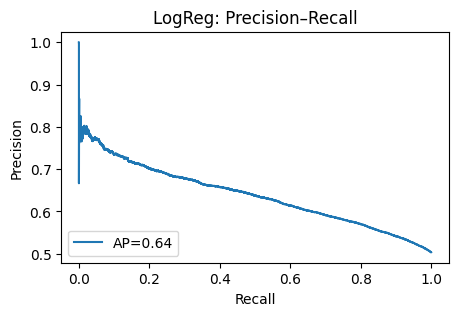


🔍 Plots for MLP


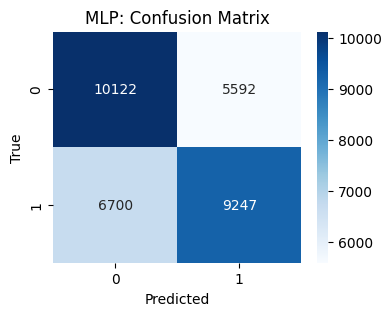

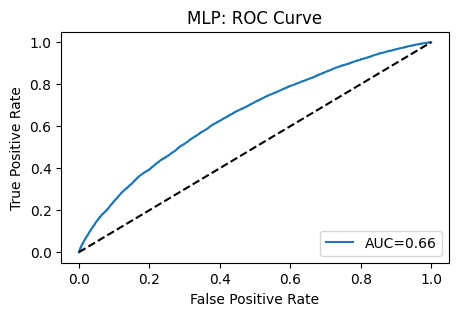

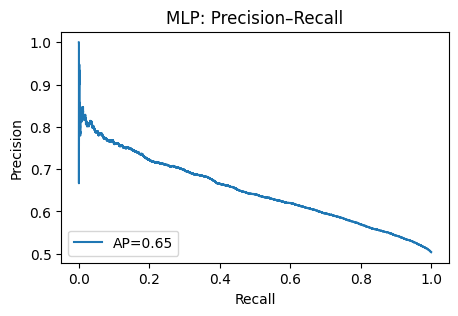

In [22]:
# Cell 13: Visualization (Confusion, ROC, PR)

import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

for name, (y_true, y_pred, y_prob) in predictions.items():
    print(f"\n🔍 Plots for {name}")

    # 1) Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name}: Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # 2) ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,3))
    plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
    plt.plot([0,1],[0,1],"k--")
    plt.title(f"{name}: ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    # 3) Precision-Recall Curve
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(rec, prec)
    plt.figure(figsize=(5,3))
    plt.plot(rec, prec, label=f"AP={pr_auc:.2f}")
    plt.title(f"{name}: Precision–Recall")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.show()


In [24]:
# Cell 14: Summary Table & Spark shutdown
metrics_df = pd.DataFrame(metrics).set_index("model")
display(metrics_df)

# Stop SparkSession
spark.stop()
print("🏁 Phase 2 complete—Spark stopped.")


,accuracy,precision,recall,f1_score,roc_auc,pr_auc
model,,,,,,
RandomForest,0.598781,0.601367,0.598781,0.596850,0.640558,0.632241
GBT,0.611762,0.611778,0.611762,0.611767,0.657899,0.651116
LogReg,0.609046,0.610930,0.609046,0.607849,0.649824,0.638257
MLP,0.611762,0.612513,0.611762,0.611386,0.656069,0.648716


🏁 Phase 2 complete—Spark stopped.
